In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import cv2 as cv

train=pd.read_csv('train.csv')
os.chdir('Train Images')
X=train['Image'].values
Xtrain=[]

for i in X:
    im = cv.imread(i)
    im = cv.resize(im,(96,96),interpolation=cv.INTER_LINEAR)
    Xtrain.append(new)
Xtrain=np.array(Xtrain)    
Xtest,Xtrain=Xtrain[:983],Xtrain[983:]
train[train['Class']=='Food']=0
train[train['Class']=='misc']=1
train[train['Class']=='Attire']=2
train[train['Class']=='Decorationandsignage']=3
ytrain=train['Class'].values
ytest,ytrain=ytrain[:983],ytrain[983:]
os.chdir('C:\Windows\System32\ML_PATH')

In [18]:
Xtrain=Xtrain.astype('float32')
Xtest=Xtest.astype('float32')
ytrain=ytrain.astype('float32')
ytest=ytest.astype('float32')
m,s=Xtrain.mean(),Xtrain.std()
def standardize(data):
    mean,std=data.mean(),data.std()
    data=(data-mean)/std
    return data   
Xtrain=standardize(Xtrain)
Xtest=(Xtest-m)/s
Xtrain,Xval=Xtrain[:4000],Xtrain[4000:]
ytrain,yval=ytrain[:4000],ytrain[4000:]

In [19]:
from sklearn.utils import class_weight
a=class_weight.compute_class_weight('balanced',np.array([0.,1.,2.,3.]),ytrain)

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rotation_range=40,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,brightness_range=(0.5,1.5),width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(Xtrain)

Using TensorFlow backend.


In [23]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,padding="SAME", use_bias=False)
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
          DefaultConv2D(filters, strides=strides),
          keras.layers.BatchNormalization(),
          self.activation,
          DefaultConv2D(filters),
            
          keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
              DefaultConv2D(filters, kernel_size=1, strides=strides),
              keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [24]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,input_shape=[96, 96, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1024,activation='elu',kernel_initializer='he_normal'))
model.add(keras.layers.Dense(4, activation="softmax"))    
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [8]:
model.load_weights('Image_Classifier.h5')
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 125 steps, validate on 1000 samples
Epoch 1/4
125/125 [==============================] - 400s 3s/step - loss: 1.8243 - accuracy: 0.3005 - val_loss: 2.2223 - val_accuracy: 0.2660
Epoch 2/4
 25/125 [=====>........................] - ETA: 5:06 - loss: 3.1909 - accuracy: 0.2850

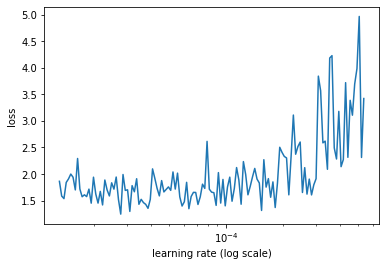

In [10]:
from keras_lr_finder import LRFinder
lr_finder=LRFinder(model)
outputs=lr_finder.find_generator(datagen.flow(Xtrain,ytrain,batch_size=32,shuffle=True),0.00001,10,validation_data=[Xval,yval],class_weight=a,epochs=4)
lr_finder.plot_loss()

In [11]:
print(np.amin(lr_finder.losses),lr_finder.lrs[np.argmin(lr_finder.losses)]) # p=0.25

1.2445245 2.7797136e-05


  ...
    to  
  ['...']
Train for 125 steps, validate on 1000 samples
Epoch 1/4
125/125 [==============================] - 384s 3s/step - loss: 1.6982 - accuracy: 0.3455 - val_loss: 2.7233 - val_accuracy: 0.2120
Epoch 2/4
  8/125 [>.............................] - ETA: 5:46 - loss: 3.0054 - accuracy: 0.2891

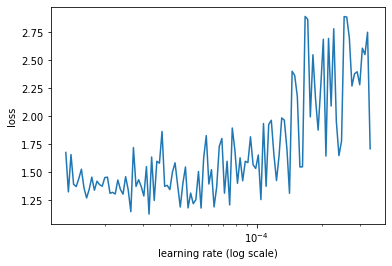

In [14]:
lr_finder=LRFinder(model)
outputs=lr_finder.find_generator(datagen.flow(Xtrain,ytrain,batch_size=32,shuffle=True),0.00001,10,validation_data=[Xval,yval],class_weight=a,epochs=4)
lr_finder.plot_loss()

In [15]:
print(np.amin(lr_finder.losses),lr_finder.lrs[np.argmin(lr_finder.losses)]) # p=0.0

1.1256394 3.191538e-05


  ...
    to  
  ['...']
Train for 125 steps, validate on 1000 samples
Epoch 1/4
125/125 [==============================] - 398s 3s/step - loss: 2.0037 - accuracy: 0.2885 - val_loss: 1.3897 - val_accuracy: 0.4010
Epoch 2/4
 22/125 [====>.........................] - ETA: 5:17 - loss: 3.0195 - accuracy: 0.2798

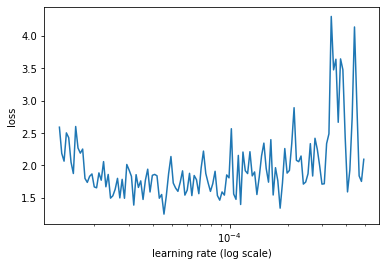

In [18]:
lr_finder=LRFinder(model)
outputs=lr_finder.find_generator(datagen.flow(Xtrain,ytrain,batch_size=32,shuffle=True),0.00001,10,validation_data=[Xval,yval],class_weight=a,epochs=4)
lr_finder.plot_loss()

In [19]:
print(np.amin(lr_finder.losses),lr_finder.lrs[np.argmin(lr_finder.losses)]) # p=0.30

1.2477338 4.5708817e-05


  ...
    to  
  ['...']
Train for 125 steps, validate on 1000 samples
Epoch 1/4
125/125 [==============================] - 404s 3s/step - loss: 891.4174 - accuracy: 0.3205 - val_loss: 641.4838 - val_accuracy: 0.2110
Epoch 2/4
108/125 [========================>.....] - ETA: 47s - loss: 223.4976 - accuracy: 0.3009

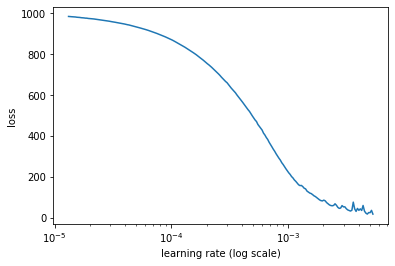

In [22]:
lr_finder=LRFinder(model)
outputs=lr_finder.find_generator(datagen.flow(Xtrain,ytrain,batch_size=32,shuffle=True),0.00001,10,validation_data=[Xval,yval],class_weight=a,epochs=4)
lr_finder.plot_loss()

In [23]:
print(np.amin(lr_finder.losses),lr_finder.lrs[np.argmin(lr_finder.losses)]) # p=0.25, wd=0.1

16.777403 0.005296637


  ...
    to  
  ['...']
Train for 125 steps, validate on 1000 samples
Epoch 1/4
125/125 [==============================] - 313s 3s/step - loss: 99.1390 - accuracy: 0.3133 - val_loss: 95.6148 - val_accuracy: 0.4010
Epoch 2/4
125/125 [==============================] - 308s 2s/step - loss: 50.8968 - accuracy: 0.3030 - val_loss: 17274484.9120 - val_accuracy: 0.2660
Epoch 3/4
 14/125 [==>...........................] - ETA: 4:26 - loss: 41.4489 - accuracy: 0.3683

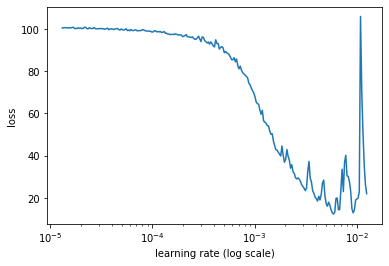

In [26]:
lr_finder=LRFinder(model)
outputs=lr_finder.find_generator(datagen.flow(Xtrain,ytrain,batch_size=32,shuffle=True),0.00001,10,validation_data=[Xval,yval],class_weight=a,epochs=4)
lr_finder.plot_loss()

In [27]:
print(np.amin(lr_finder.losses),lr_finder.lrs[np.argmin(lr_finder.losses)]) # p=0.25, wd=0.01

12.33492 0.0059156194


In [ ]:
n_epochs = 20
batch_size=32
def exp(epoch):
    return  0.005*0.1**(epoch/60)
lr=keras.callbacks.LearningRateScheduler(exp)
history = model.fit(Xtrain, ytrain,batch_size=batch_size, epochs=n_epochs, validation_data=[Xval,yval],class_weight=a)          

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 293s 73ms/sample - loss: 1.6320 - accuracy: 0.3680 - val_loss: 2.0608 - val_accuracy: 0.2660
Epoch 2/20
4000/4000 [==============================] - 281s 70ms/sample - loss: 1.4026 - accuracy: 0.3915 - val_loss: 1.3226 - val_accuracy: 0.4340
Epoch 3/20
4000/4000 [==============================] - 277s 69ms/sample - loss: 1.2466 - accuracy: 0.4595 - val_loss: 1.5233 - val_accuracy: 0.3240
Epoch 4/20
2816/4000 [====================>.........] - ETA: 1:19 - loss: 1.1788 - accuracy: 0.4968

In [ ]:
history = model.fit_generator(datagen.flow(Xtrain, ytrain,batch_size=32), epochs=100,initial_epoch=80, validation_data=[Xval,yval],class_weight=a)          

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 125 steps, validate on 1000 samples
Epoch 81/100
125/125 [==============================] - 394s 3s/step - loss: 1.0050 - accuracy: 0.5847 - val_loss: 1.4743 - val_accuracy: 0.2660
Epoch 82/100
125/125 [==============================] - 396s 3s/step - loss: 0.9909 - accuracy: 0.5785 - val_loss: 9.3424 - val_accuracy: 0.4010
Epoch 83/100
125/125 [==============================] - 388s 3s/step - loss: 0.9811 - accuracy: 0.5985 - val_loss: 3.8685 - val_accuracy: 0.2660
Epoch 84/100
  6/125 [>.............................] - ETA: 6:07 - loss: 1.0219 - accuracy: 0.5781

In [12]:
model.save_weights('Image_Classifier.h5')